<a href="https://colab.research.google.com/github/jonelrelucio/AN2DL-2025/blob/testing/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import os
from itertools import product



from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import f1_score

SEED = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cpu


In [33]:
df_train = pd.read_csv('pirate_pain_train.csv')

float_cols = df_train.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_train[col] = df_train[col].astype(np.float32)

df_train.head()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [34]:
df_labels = pd.read_csv('pirate_pain_train_labels.csv')
df_labels.head()



,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [35]:
label_counts = df_labels['label'].value_counts()
display(label_counts)

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [45]:
df_merged = pd.merge(df_train, df_labels, on='sample_index')
df_merged.size

4336160

In [37]:
nan_counts = df_merged.isnull().sum()
display(nan_counts[nan_counts > 0])

,0


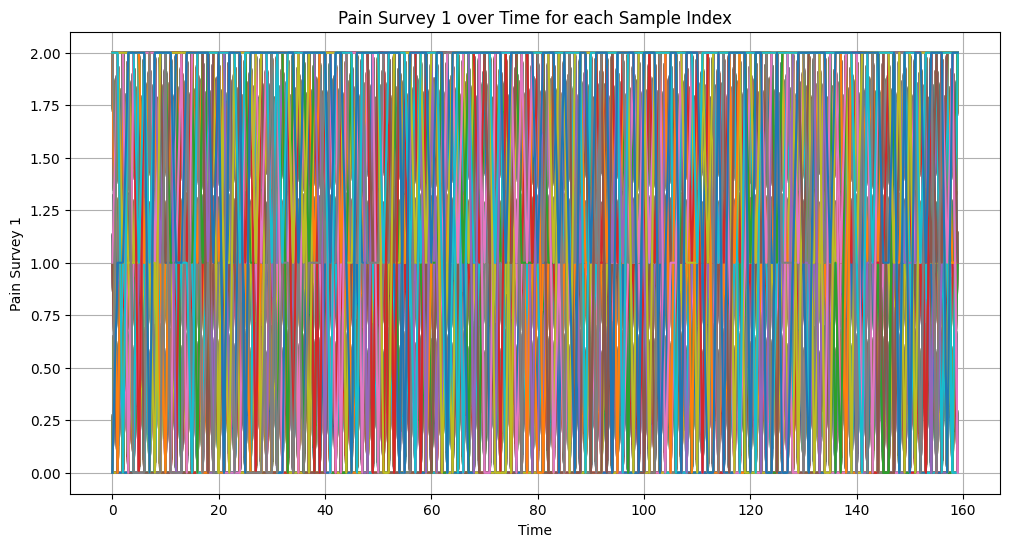

In [38]:
plt.figure(figsize=(12, 6))
for sample_idx in df_merged['sample_index'].unique():
    subset = df_merged[df_merged['sample_index'] == sample_idx]
    plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for each Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

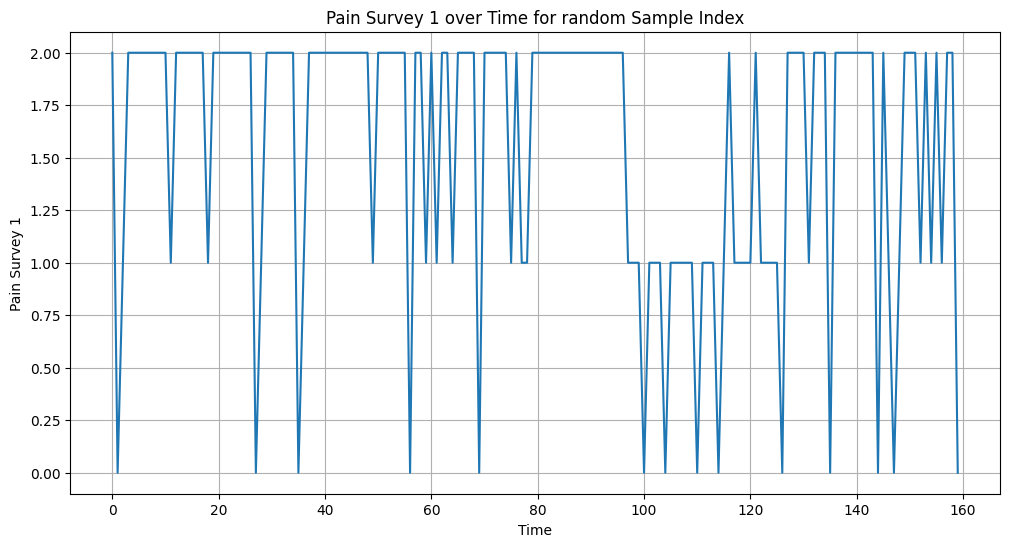

In [39]:
plt.figure(figsize=(12, 6))
sample_idx = random.choice(df_merged['sample_index'].unique())
subset = df_merged[df_merged['sample_index'] == sample_idx]
plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for random Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

In [14]:
label_counts = df_merged['n_legs'].value_counts()
display(label_counts)

,count
n_legs,
two,63441
one+peg_leg,800


In [15]:
label_counts = df_merged['n_eyes'].value_counts()
display(label_counts)

,count
n_eyes,
two,63441
one+eye_patch,800


In [16]:
label_counts = df_merged['n_hands'].value_counts()
display(label_counts)

,count
n_hands,
two,63441
one+hook_hand,800


In [17]:
unusual_samples = df_merged[
    (df_merged['n_eyes'] != 'two') |
    (df_merged['n_legs'] != 'two') |
    (df_merged['n_hands'] != 'two')
]

display(unusual_samples[['sample_index', 'label']].drop_duplicates().reset_index(drop=True))

,sample_index,label
0,8,no_pain
1,137,no_pain
2,216,no_pain
3,338,low_pain
4,350,no_pain


In [18]:
unusual_sample_indices = unusual_samples['sample_index'].unique()
unusual_labels = df_labels[df_labels['sample_index'].isin(unusual_sample_indices)]

display(unusual_labels)

,sample_index,label
8,8,no_pain
137,137,no_pain
216,216,no_pain
338,338,low_pain
350,350,no_pain


In [26]:
df_unusual_first_timestamp = df_merged[
    (df_merged['sample_index'].isin(unusual_sample_indices)) &
    (df_merged['time'] == 0)
]
display(df_unusual_first_timestamp[['sample_index', 'n_legs', 'n_hands', 'n_eyes', 'label']])

,sample_index,n_legs,n_hands,n_eyes,label
1280,8,one+peg_leg,one+hook_hand,one+eye_patch,no_pain
21920,137,one+peg_leg,one+hook_hand,one+eye_patch,no_pain
34560,216,one+peg_leg,one+hook_hand,one+eye_patch,no_pain
54080,338,one+peg_leg,one+hook_hand,one+eye_patch,low_pain
56000,350,one+peg_leg,one+hook_hand,one+eye_patch,no_pain


In [20]:
df_test = pd.read_csv('/content/drive/MyDrive/ANN/pirate_pain_test.csv')

In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float64
 10  joint_01       211840 non-null  float64
 11  joint_02       211840 non-null  float64
 12  joint_03       211840 non-null  float64
 13  joint_04       211840 non-null  float64
 14  joint_05       211840 non-null  float64
 15  joint_06       211840 non-null  float64
 16  joint_07       211840 non-null  float64
 17  joint_08       211840 non-nul

In [22]:
df_test.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,...,211840.000000,211840.000000,2.118400e+05,2.118400e+05,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.0
mean,661.500000,79.500000,1.615384,1.665625,1.657501,1.663293,0.984106,1.002312,0.833719,0.839993,...,0.000032,0.000024,4.138805e-05,3.408469e-05,0.000107,0.040524,0.060134,0.052490,0.061218,0.5
std,382.206671,46.187228,0.703560,0.659999,0.666037,0.662678,0.204744,0.191175,0.298458,0.298573,...,0.001464,0.000413,5.570593e-04,6.285418e-04,0.001203,0.057234,0.078081,0.058698,0.066651,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036813,0.014754,0.047624,...,0.000002,0.000001,0.000000e+00,0.000000e+00,0.000000,0.000000,0.004475,0.004083,0.000000,0.5
25%,330.750000,39.750000,1.000000,2.000000,2.000000,2.000000,0.867980,0.897176,0.625202,0.604872,...,0.000003,0.000003,4.412668e-07,2.325231e-07,0.000000,0.010886,0.017376,0.020317,0.021007,0.5
50%,661.500000,79.500000,2.000000,2.000000,2.000000,2.000000,1.040931,1.063110,0.969119,0.979624,...,0.000004,0.000004,2.527479e-06,2.060598e-06,0.000006,0.022146,0.033317,0.035334,0.038696,0.5
75%,992.250000,119.250000,2.000000,2.000000,2.000000,2.000000,1.128461,1.139088,1.052242,1.060542,...,0.000006,0.000006,4.590578e-06,3.708785e-06,0.000014,0.046722,0.069825,0.061336,0.077690,0.5
max,1323.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.500341,1.499030,1.346970,1.333893,...,0.389906,0.062781,6.476609e-02,1.249919e-01,0.167318,1.299322,1.375895,1.412636,1.333794,0.5


In [23]:
df_test['sample_index'].nunique()

1324

In [24]:
unusual_samples = df_test[
    (df_test['n_eyes'] != 'two') |
    (df_test['n_legs'] != 'two') |
    (df_test['n_hands'] != 'two')
]

print(unusual_samples[['sample_index']].nunique())

df_unusual_first_timestamp = df_test[
    (df_test['sample_index'].isin(unusual_sample_indices)) &
    (df_test['time'] == 0)
]
display(df_unusual_first_timestamp[['sample_index', 'n_legs', 'n_hands', 'n_eyes']])

sample_index    13
dtype: int64


,sample_index,n_legs,n_hands,n_eyes
1280,8,two,two,two
21920,137,two,two,two
34560,216,two,two,two
54080,338,two,two,two
56000,350,two,two,two


In [50]:
df_high = df_merged[df_merged['label'] == 'high_pain']
df_low = df_merged[df_merged['label'] == 'low_pain']
df_no = df_merged[df_merged['label'] == 'no_pain' ]

df_high.describe()
joint_columns = [c for c in df_merged.columns if c.startswith('joint_')]
joint_columns = joint_columns[:-1]
columns = ['time'] + joint_columns

df_high_mean = df_high[columns].mean()
df_low_mean = df_low[columns].mean()
df_no_mean = df_no[columns].mean()

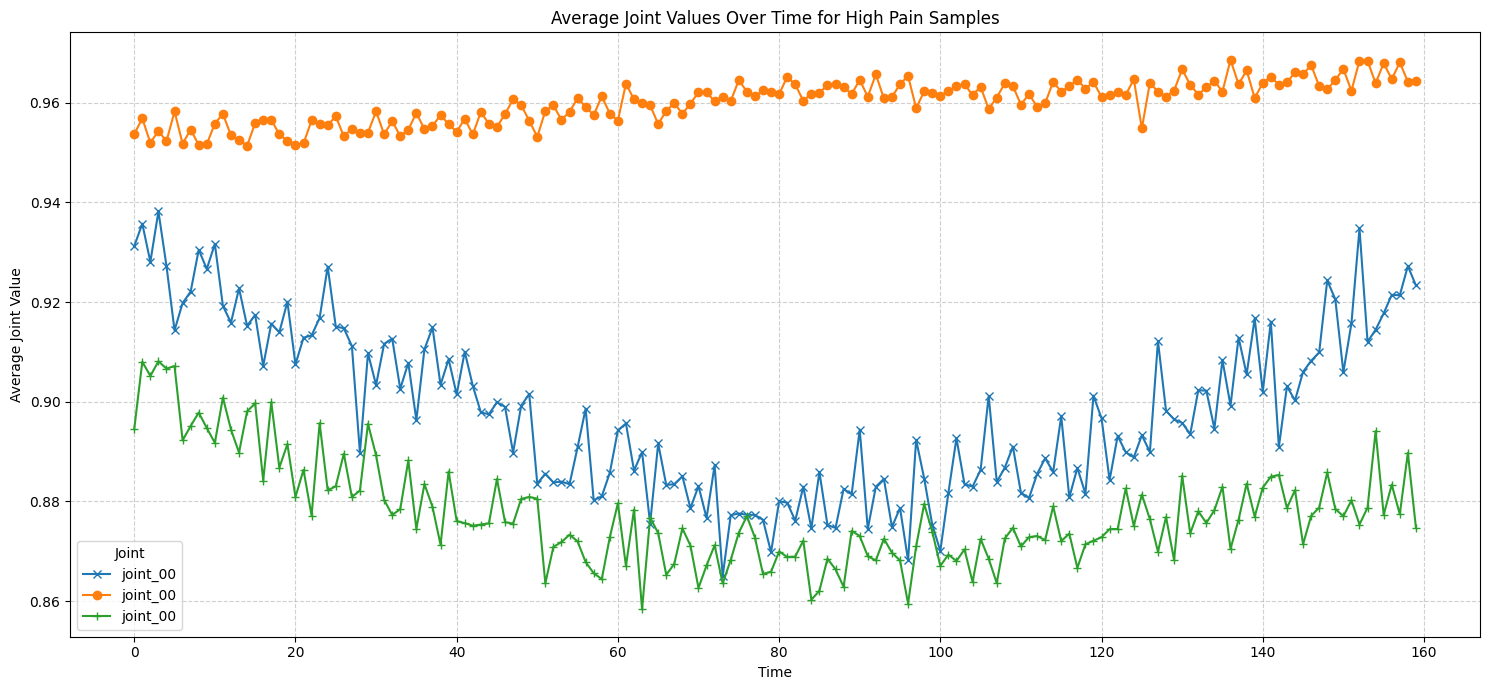

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [56]:
df_high_time_evolution = df_high.groupby('time')[joint_columns].mean()
df_low_time_evolution = df_low.groupby('time')[joint_columns].mean()
df_no_time_evolution = df_no.groupby('time')[joint_columns].mean()
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_00']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

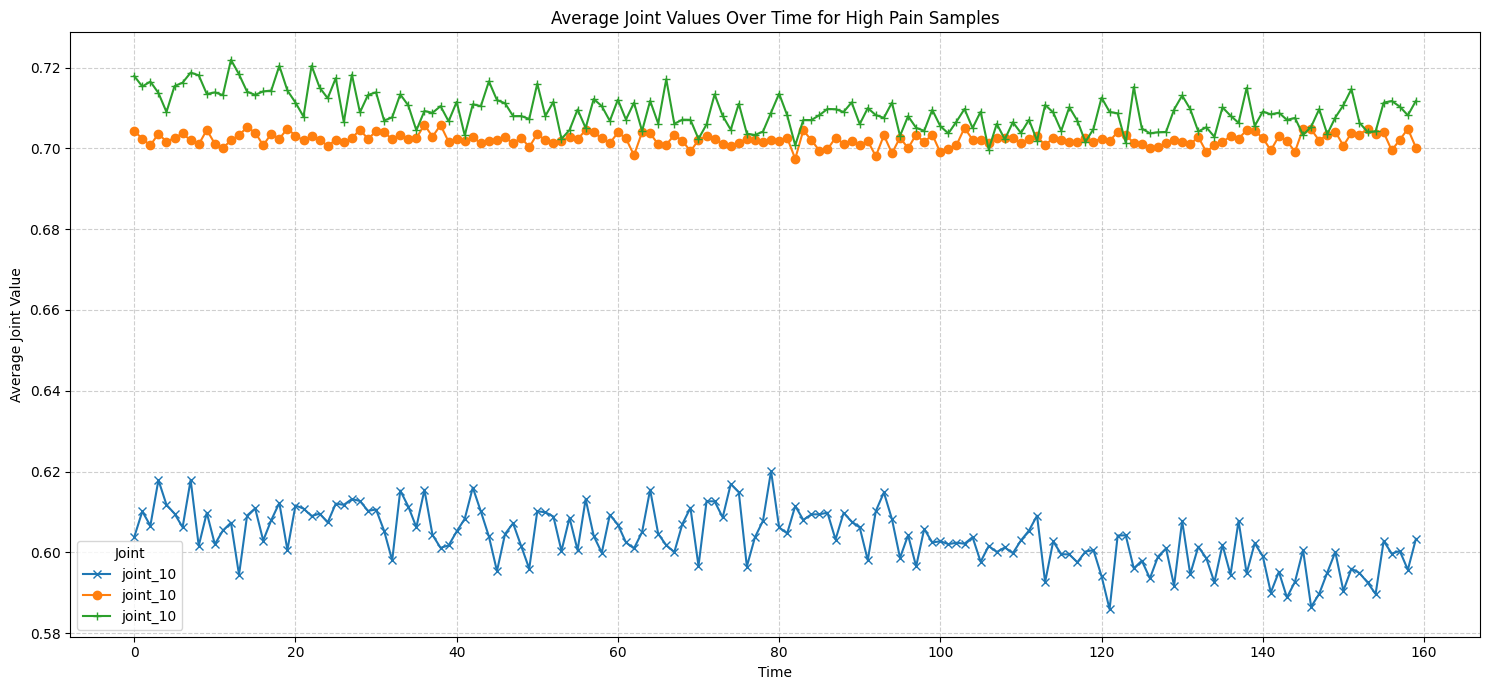

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [57]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_10']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

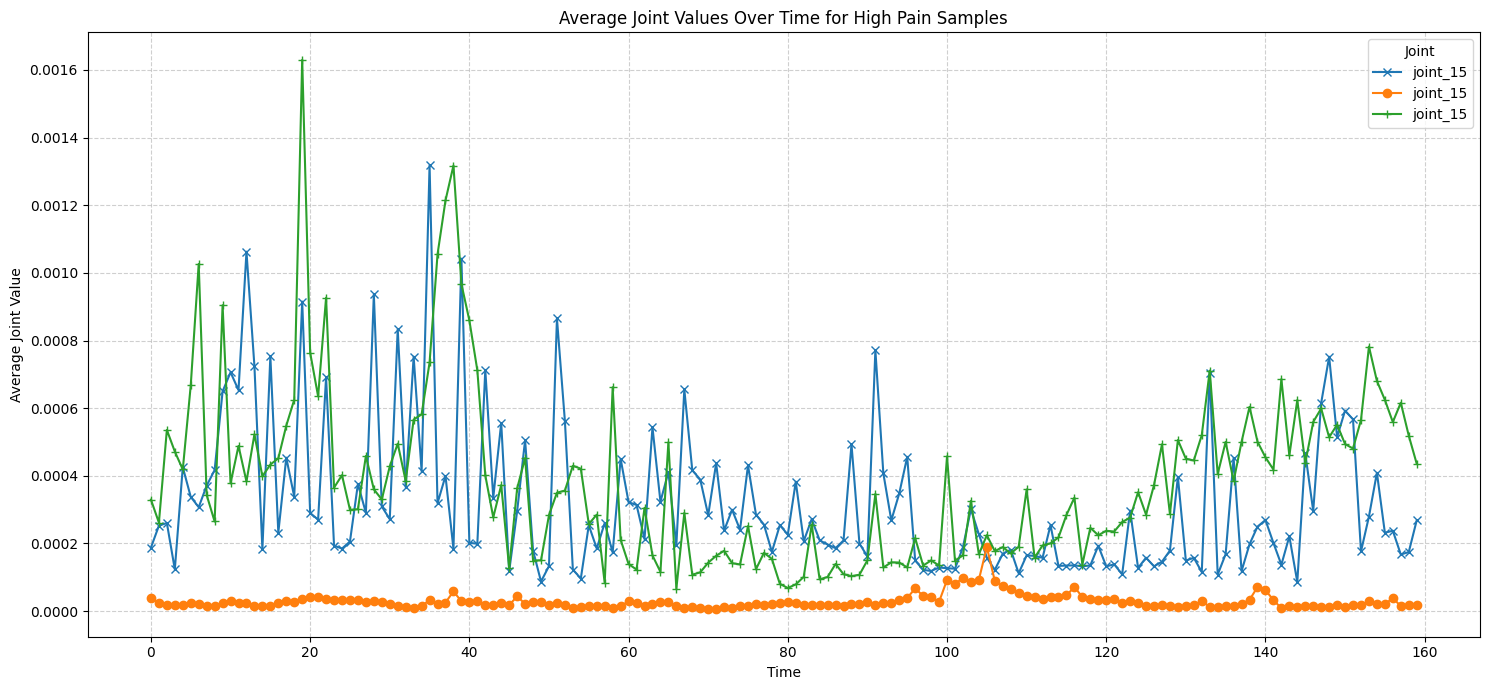

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [60]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_15']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

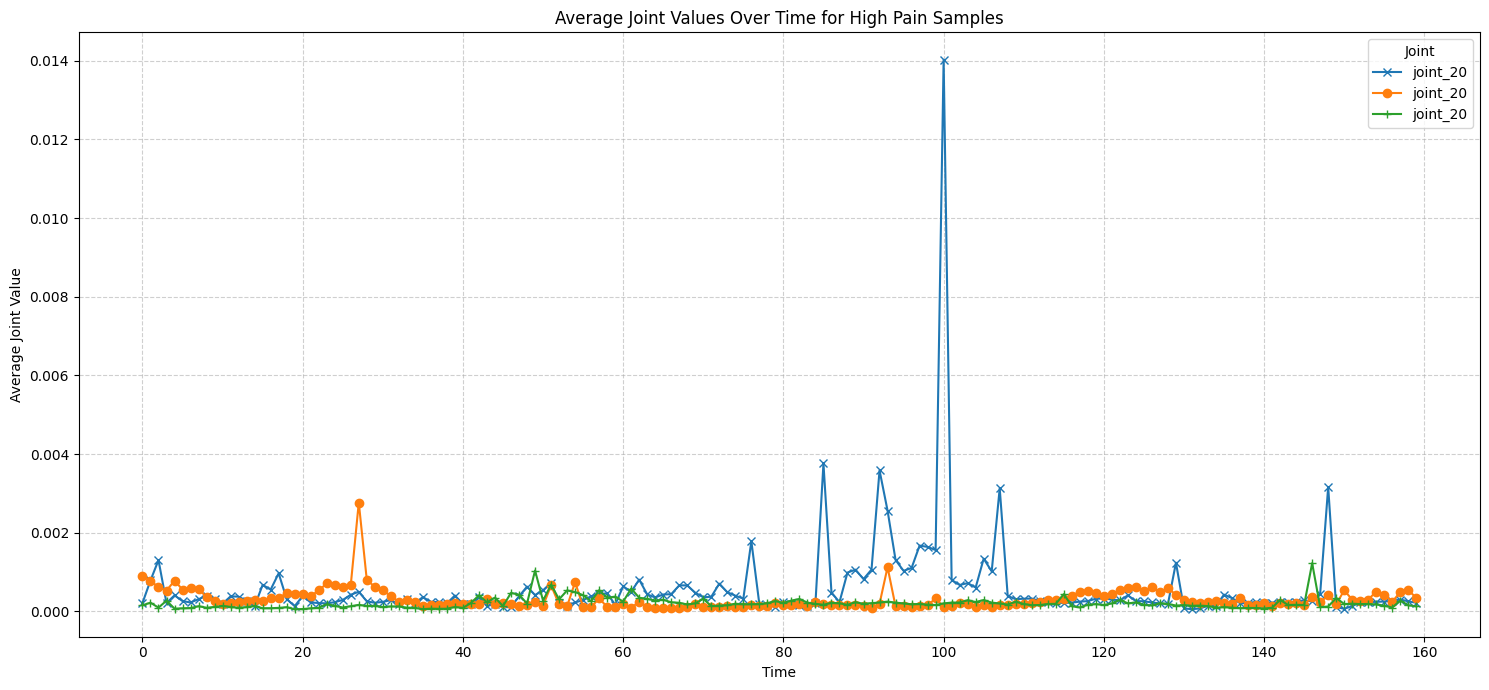

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [58]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_20']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

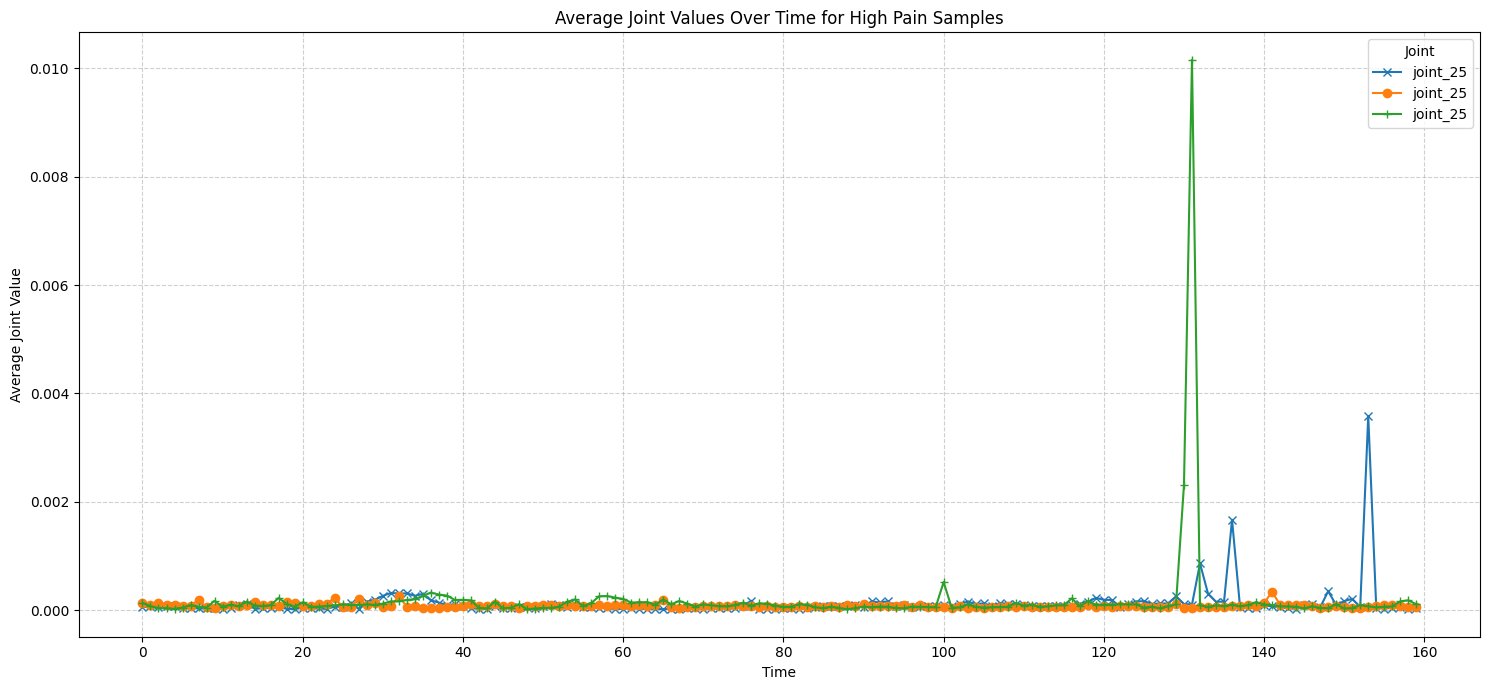

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [59]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_25']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())